In [13]:
# Importing Important libraries 

# For data cleaning and visualization
import math
import pandas as pd
import numpy as np
from numpy import array
from datetime import date, datetime, timedelta


# For model
from numpy import newaxis
import keras
from keras import optimizers, callbacks
from keras.layers import InputLayer, Input, Masking, Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers, callbacks

# For saving the model
import pickle

# For Prediction 
from numpy import newaxis

# For model Evaluation
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# For Plotting 
import matplotlib.pyplot as plt
from pylab import rcParams 

In [14]:
company_tickers = ['AAPL','AMZN','ADM', 'GOOG', 'EBAY', 'XOM', 'ABT']

In [15]:
def create_windows(data, data_len, sequence_len=10):
  data_windows = []
  for i in range(data_len - sequence_len):
    data_windows.append(data[i : i+sequence_len])

  # set the type of training data     
  data_windows = np.array(data_windows).astype(float)
  return (data_windows)

In [16]:
def Normalize_data(data_windows):
  # number of windows formed 
  windows_no = data_windows.shape[0]
  cols_no = data_windows.shape[2]

  # initializing list to store normalized data
  normalized_data = []
  record_min=[]
  record_max=[]

  # normalizing begins
  for win_index in range(windows_no):
    normalized_window = []

    for col_index in range(0,1):
      # temporary column 
      t_col = data_windows[win_index, :, col_index]
      t_min = min(t_col)
      if (col_index == 0):
        record_min.append(t_min)
      t_col = t_col - t_min      
      t_max = max(t_col)
      if (col_index == 0):
        record_max.append(t_max)
      t_col = t_col/t_max
      normalized_window.append(t_col)
    
    for col_index in range(1,  cols_no):
      t_col = data_windows[win_index, :, col_index]
      normalized_window.append(t_col)

    normalized_window = np.array(normalized_window).T
    normalized_data.append(normalized_window)

  normalized_data=np.array(normalized_data)
  return (normalized_data, record_max, record_min)


In [17]:
def plot_training_loss(model_hist):
  # plotting the lose curve during model training
  plt.plot(model_hist.history['loss'])
  plt.title('Training Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train'],loc='upper left')
  plt.show()


In [18]:
def Model_Evaluation(actual_prices, predicted_prices):
  # Mean Absolute Error 
  MAE = metrics.mean_absolute_error(actual_prices, predicted_prices)
  # Mean Squared Error
  MSE = metrics.mean_squared_error(actual_prices, predicted_prices)
  # Root Mean Squared Error
  RMSE = np.sqrt(metrics.mean_squared_error(actual_prices, predicted_prices))

  # Mean Absolute Percentage Error in degrees
  errors = abs(actual_prices - predicted_prices)
  MAPE = 100 * (errors /actual_prices)

  # Model Accuracy
  Accuracy = 100 - np.mean(MAPE)
  return (Accuracy, MAE, MSE, RMSE)

In [19]:
def DP_LSTM(company, df):
  # Adding noise to dataset
  # calculating the variance of the mean_compound column
  news_column  = 'mean_compound'
  mc_var=np.var(df.mean_compound)
  mu=0
  noise=0.1
  sigma_noise = noise*mc_var
  n = df.shape[0]
  # create a dataframe for noise
  df_noise = pd.DataFrame()
  df_noise['mc_noise'] = df[news_column]
  for i in range(0,n):
      df_noise['mc_noise'][i]+=np.random.normal(mu,sigma_noise)  
  noise_name = "mc_noise_"+company+".csv"    
  df_noise.to_csv(noise_name)
  dfn = pd.read_csv(noise_name,index_col=0)
  # creating one dataframe by adding noise in news columns 
  df1 = pd.DataFrame()
  df1['price'] = df['adj_close']
  df1['mc'] = dfn['mc_noise']
  # creating another dataframe by adding normal noise column 
  df2 = pd.DataFrame()
  df2['price'] = df['adj_close']
  df2['mc'] = df['mean_compound']

  # choosing columns for the model
  cols = ['price','mc']
  # deciding the split size
  split = 0.85
  sequence_length=10;
  split_index = int(len(df1) * split)
  data_train1 = df1.get(cols).values[:split_index]
  data_train2 = df2.get(cols).values[:split_index]
  train_len  = len(data_train1)
  train_windows_len = None

  # Normalizing Train data1
  data_windows1 = create_windows(data_train1,train_len,sequence_length)
  normalized_data1,rmax_t1, rmin_t1 = Normalize_data(data_windows1)

  x_train1 = normalized_data1[:, :-1]
  y_train1 = normalized_data1[:, -1,[0]]

  # Normalizing Train data2
  data_windows2 = create_windows(data_train2, train_len,sequence_length)
  normalized_data2,rmax_t2, rmin_t2 = Normalize_data(data_windows2)

  x_train2 = normalized_data2[:, :-1]
  y_train2 = normalized_data2[:, -1,[0]]

  # concatenating the training data
  x_train = np.concatenate((x_train1,x_train2),axis=0)
  y_train = np.concatenate((y_train1,y_train2),axis=0)
  x_train.shape, y_train.shape

  #x_train = x_train1
  #y_train = y_train1

  # Creating the Test Data
  df_test = pd.read_csv(df_name, index_col = 0)
  df_test = df_test.rename(columns = {'adj_close': 'price','mean_compound':'mc'})
  #df_test['date'] = pd.to_datetime(df_test['date'])
  cols = ['price','mc']
  cols2 = ['date']
  test_len = df_test.shape[0]

  data_test  = df_test.get(cols).values[split_index:]
  data_test2  = df_test.get(cols2).values[split_index:]

  data_windows_test = create_windows(data_test, len(data_test), sequence_length)
  # the last price value of each window is the original y_test
  y_test_original = data_windows_test[:, -1, [0]]

  normalized_data_test, record_max_test, record_min_test = Normalize_data(data_windows_test)

  x_test = normalized_data_test[:, :-1]
  y_test = normalized_data_test[:, -1,[0]]

  
  
  # Setting the parameters  
  input_dim=x_train.shape[2] #2
  input_timesteps=x_train.shape[1] #9

  #LSTM Model
  model = Sequential()
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,input_shape=(input_timesteps, input_dim)))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 120, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1))
  model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])
  hist = model.fit(x_train, y_train, epochs=30, batch_size=32)

  

  plot_training_loss(hist)
  #model_name = company+'_stock_predict_LSTM' 
  #model.save('saved_model/'+model_name)
  # Loading the model
  #model = tf.keras.models.load_model('saved_model/stock_predict_LSTM')

  # Prediction of Test Data using the Training Model
  # Using the trained model for prediction and check the performance metrics
  train_predict = model.predict(x_train)
  test_predict = model.predict(x_test)
  # Multi-sequence Prediction
  # predicting x_test
  prediction_len = 1
  # x_test needs to be predicted 
  data = x_test
  predicted_vals = []
  window_size = sequence_length
  pre_win_no = int(len(data)/prediction_len)
  for i in range(pre_win_no):
    # access x_test window by window
    curr_frame = data[i*prediction_len]
    pred = []
    for j in range(prediction_len):
      # increase the dimension of current frame by one using newaxis, so that it can be fed to model for prediction
      model_predict = model.predict(curr_frame[newaxis,:,:])[0]
      pred.append(model_predict)
      # shift the current frame forward
      curr_frame = curr_frame[1:]
      # insert the currently predicted value in the frame
      # add the new predicted value at the end of window frame 
      curr_frame = np.insert(curr_frame, [window_size-2], pred[-1], axis=0)
    predicted_vals.append(pred)
  print(len(predicted_vals))
  # Denormalizing the Prediction Results to get Predicted Adj Close Price

  pred_prices = []
  len_pre_win = int(len(data)/prediction_len)
  cnt=0
  for i in range(0,len_pre_win):
      for j in range(0,prediction_len):
        pred_prices.append(predicted_vals[i][j][0]*record_max_test[cnt]+record_min_test[cnt])
        cnt = cnt+1


  # Comparing Actual and Predicted Prices
  actual_prices = []
  for i in y_test_original.tolist():
    actual_prices.append(i[0])
  dates = []
  for i in data_test2.tolist():
    dates.append(i[0])
  dates = dates[len(dates)-len(actual_prices):]
  res = { 'date':dates,
        'Actual': actual_prices,
        'Predicted': pred_prices
        }
  df_compare = pd.DataFrame(res,columns = ['date','Actual','Predicted'])
  print(df_compare)

  # Performance Evaluation
  actual_prices = df_compare['Actual']
  predicted_prices = df_compare['Predicted']  

  Accuracy, MAE, MSE, RMSE = Model_Evaluation(actual_prices, predicted_prices)
  print("\n-----Model Evaluation-----------------------------------------------------\n")
  print("LSTM Model Loss = ", model.evaluate(x_test, y_test, verbose = 2))
  print("Model Accuracy = ", Accuracy)
  print("Mean Absolute Error = ", MAE," degrees")
  print("Mean Squared Error = ", MSE)
  print("Root Mean Squared Error = ", RMSE)
  print("\n--------------------------------------------------------------------------\n")
  
  return (hist, model, df_compare, Accuracy, MAE, MSE, RMSE)


In [20]:
company_results = pd.DataFrame(columns=('company','MAE','MSE','Accuracy','RMSE'))
company_results

,company,MAE,MSE,Accuracy,RMSE


,company,MAE,MSE,Accuracy,RMSE


Evaluating Model for Company:  AAPL
Epoch 1/30
92/92 [==============================] - 11s 51ms/step - loss: 0.2485 - mean_squared_error: 0.2485
Epoch 2/30
92/92 [==============================] - 5s 51ms/step - loss: 0.0913 - mean_squared_error: 0.0913
Epoch 3/30
92/92 [==============================] - 5s 54ms/step - loss: 0.0805 - mean_squared_error: 0.0805
Epoch 4/30
92/92 [==============================] - 5s 51ms/step - loss: 0.0792 - mean_squared_error: 0.0792
Epoch 5/30
92/92 [==============================] - 5s 53ms/step - loss: 0.0795 - mean_squared_error: 0.0795
Epoch 6/30
92/92 [==============================] - 5s 53ms/step - loss: 0.0780 - mean_squared_error: 0.0780
Epoch 7/30
92/92 [==============================] - 5s 55ms/step - loss: 0.0786 - mean_squared_error: 0.0786
Epoch 8/30
92/92 [==============================] - 5s 54ms/step - loss: 0.0764 - mean_squared_error: 0.0764
Epoch 9/30
92/92 [==============================] - 5s 53ms/step - loss: 0.0743 - mean_squa

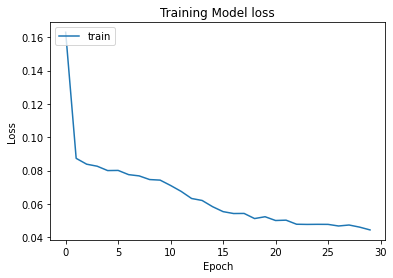

251
           date     Actual  Predicted
0    2019-01-30  37.715031  38.140222
1    2019-01-31  40.292267  40.303497
2    2019-02-01  40.582428  40.463822
3    2019-02-04  40.601936  40.105111
4    2019-02-05  41.755226  41.381165
..          ...        ...        ...
246  2020-01-22  78.347801  77.712229
247  2020-01-23  78.627464  78.038437
248  2020-01-24  79.006119  78.468940
249  2020-01-27  78.778435  78.262640
250  2020-01-28  76.461929  76.415682

[251 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

8/8 - 1s - loss: 0.0402 - mean_squared_error: 0.0402
LSTM Model Loss =  [0.040176715701818466, 0.040176715701818466]
Model Accuracy =  99.27124415033072
Mean Absolute Error =  0.38945769650627016  degrees
Mean Squared Error =  0.28466172836940634
Root Mean Squared Error =  0.5335369981260966

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
Epoch 1/30
73/73 [===============

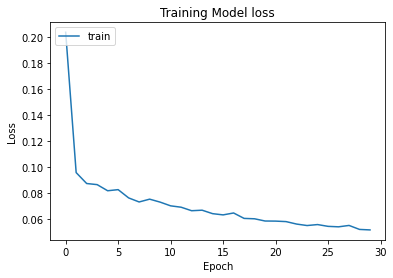

197
           date       Actual    Predicted
0    2019-04-12  1844.069946  1831.431279
1    2019-04-15  1843.060059  1841.966747
2    2019-04-17  1844.869995  1839.824357
3    2019-04-22  1864.819946  1857.340464
4    2019-04-23  1887.310059  1881.726095
..          ...          ...          ...
192  2020-01-30  1858.000000  1847.855439
193  2020-01-31  1870.680054  1855.117406
194  2020-02-03  2008.719971  1982.362380
195  2020-02-04  2004.199951  1982.846713
196  2020-02-05  2049.669922  2028.388853

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0510 - mean_squared_error: 0.0510
LSTM Model Loss =  [0.05097583308815956, 0.05097583308815956]
Model Accuracy =  99.19322077898427
Mean Absolute Error =  14.861266762113441  degrees
Mean Squared Error =  403.7968414686182
Root Mean Squared Error =  20.094696849383375

--------------------------------------------------------------------------

Evaluating Model for Compa

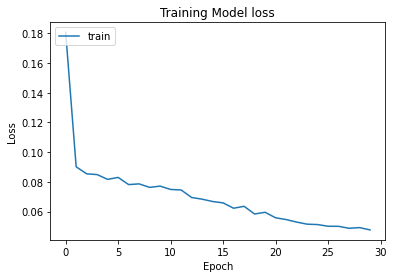

197
           date     Actual  Predicted
0    2019-04-12  40.507534  40.143857
1    2019-04-15  40.591747  40.316223
2    2019-04-17  40.554325  40.204937
3    2019-04-22  40.273605  39.975192
4    2019-04-23  39.918026  39.923006
..          ...        ...        ...
192  2020-01-30  41.956577  42.236650
193  2020-01-31  43.992935  42.897683
194  2020-02-03  42.993965  43.057173
195  2020-02-04  43.186077  43.138949
196  2020-02-05  43.579899  43.181382

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0472 - mean_squared_error: 0.0472
LSTM Model Loss =  [0.047211214900016785, 0.047211214900016785]
Model Accuracy =  99.2292788392067
Mean Absolute Error =  0.3042321057303491  degrees
Mean Squared Error =  0.17338429789549667
Root Mean Squared Error =  0.4163944018541756

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
Epoch 1/30
73/73 [=================

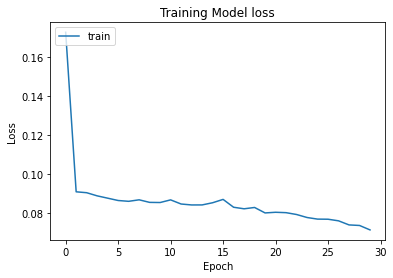

197
           date       Actual    Predicted
0    2019-04-12  1204.619995  1194.977556
1    2019-04-15  1217.869995  1214.659923
2    2019-04-17  1221.099976  1216.426899
3    2019-04-22  1236.339966  1231.176340
4    2019-04-23  1248.839966  1242.292433
..          ...          ...          ...
192  2020-01-30  1458.630005  1445.233230
193  2020-01-31  1455.839966  1445.136043
194  2020-02-03  1434.229980  1450.452054
195  2020-02-04  1485.939941  1452.463313
196  2020-02-05  1447.069946  1452.147274

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0838 - mean_squared_error: 0.0838
LSTM Model Loss =  [0.08377311378717422, 0.08377311378717422]
Model Accuracy =  98.94152093106018
Mean Absolute Error =  12.960440201475325  degrees
Mean Squared Error =  284.9175112815011
Root Mean Squared Error =  16.87949973433754

--------------------------------------------------------------------------

Evaluating Model for Compan

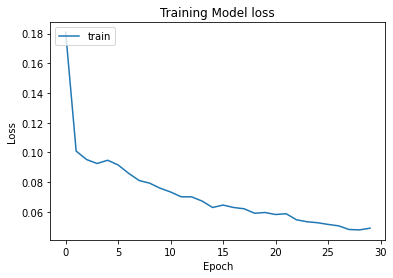

197
           date     Actual  Predicted
0    2019-04-12  35.292530  35.345657
1    2019-04-15  35.146770  35.277592
2    2019-04-17  35.205078  35.426740
3    2019-04-22  34.952431  35.038443
4    2019-04-23  35.127342  35.066566
..          ...        ...        ...
192  2020-01-30  33.982201  34.011714
193  2020-01-31  34.453903  34.146114
194  2020-02-03  32.979836  33.046968
195  2020-02-04  33.795483  33.294928
196  2020-02-05  36.763275  34.949432

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0597 - mean_squared_error: 0.0597
LSTM Model Loss =  [0.05972469225525856, 0.05972469225525856]
Model Accuracy =  99.20631357647
Mean Absolute Error =  0.29522424563173544  degrees
Mean Squared Error =  0.16119674483989754
Root Mean Squared Error =  0.4014931442003681

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
Epoch 1/30
73/73 [=====================

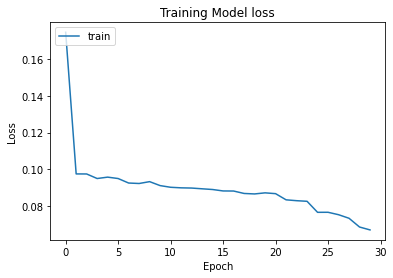

197
           date     Actual  Predicted
0    2019-04-12  72.001968  72.531005
1    2019-04-15  71.097000  72.278069
2    2019-04-17  70.859787  71.722650
3    2019-04-22  71.545097  71.810139
4    2019-04-23  72.836647  71.875393
..          ...        ...        ...
192  2020-01-30  58.377277  58.846479
193  2020-01-31  58.996475  59.284671
194  2020-02-03  56.565224  56.701141
195  2020-02-04  55.299515  55.404435
196  2020-02-05  54.607475  54.857719

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0586 - mean_squared_error: 0.0586
LSTM Model Loss =  [0.05862995982170105, 0.05862995982170105]
Model Accuracy =  99.27242141767786
Mean Absolute Error =  0.4691081162873204  degrees
Mean Squared Error =  0.38637352927633145
Root Mean Squared Error =  0.6215895183127942

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
Epoch 1/30
73/73 [===================

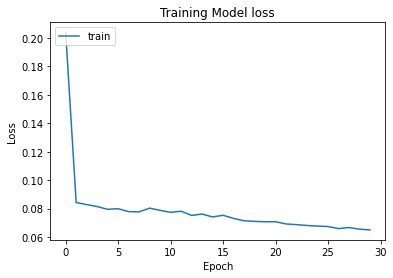

197
           date     Actual  Predicted
0    2019-04-12  76.076523  76.588434
1    2019-04-15  75.901398  76.187600
2    2019-04-17  75.405174  75.531134
3    2019-04-22  70.910042  70.984464
4    2019-04-23  72.495987  71.175027
..          ...        ...        ...
192  2020-01-30  87.775566  89.121474
193  2020-01-31  87.795273  89.215944
194  2020-02-03  85.806183  86.251030
195  2020-02-04  85.727409  86.055581
196  2020-02-05  86.879509  86.513071

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0863 - mean_squared_error: 0.0863
LSTM Model Loss =  [0.08625248074531555, 0.08625248074531555]
Model Accuracy =  99.09954272450824
Mean Absolute Error =  0.7280239700877614  degrees
Mean Squared Error =  0.9342428976674343
Root Mean Squared Error =  0.9665624127118922

--------------------------------------------------------------------------

Evaluating Model for Company:  AAPL
Epoch 1/30
92/92 [===================

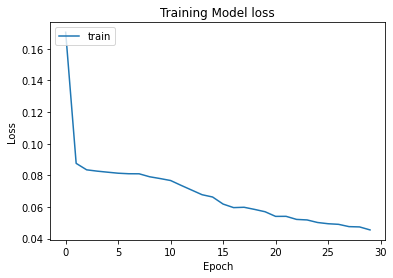

251
           date     Actual  Predicted
0    2019-01-30  37.715031  38.022623
1    2019-01-31  40.292267  40.349924
2    2019-02-01  40.582428  40.465127
3    2019-02-04  40.601936  40.070982
4    2019-02-05  41.755226  41.509610
..          ...        ...        ...
246  2020-01-22  78.347801  77.202810
247  2020-01-23  78.627464  77.607777
248  2020-01-24  79.006119  78.339568
249  2020-01-27  78.778435  78.273058
250  2020-01-28  76.461929  76.558990

[251 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

8/8 - 0s - loss: 0.0419 - mean_squared_error: 0.0419
LSTM Model Loss =  [0.04194541648030281, 0.04194541648030281]
Model Accuracy =  99.21350115176277
Mean Absolute Error =  0.4189887115526949  degrees
Mean Squared Error =  0.31396702418633027
Root Mean Squared Error =  0.560327604340827

--------------------------------------------------------------------------

Evaluating Model for Company:  AMZN
Epoch 1/30
73/73 [===================

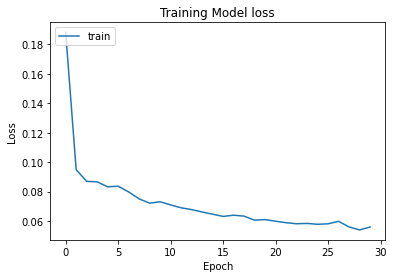

197
           date       Actual    Predicted
0    2019-04-12  1844.069946  1830.632209
1    2019-04-15  1843.060059  1842.552180
2    2019-04-17  1844.869995  1840.349396
3    2019-04-22  1864.819946  1857.613039
4    2019-04-23  1887.310059  1878.603413
..          ...          ...          ...
192  2020-01-30  1858.000000  1847.013928
193  2020-01-31  1870.680054  1853.014003
194  2020-02-03  2008.719971  1979.932168
195  2020-02-04  2004.199951  1981.116014
196  2020-02-05  2049.669922  2024.012732

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0524 - mean_squared_error: 0.0524
LSTM Model Loss =  [0.05240609496831894, 0.05240609496831894]
Model Accuracy =  99.18858439795284
Mean Absolute Error =  14.957059139725306  degrees
Mean Squared Error =  415.60538978538955
Root Mean Squared Error =  20.38640208044052

--------------------------------------------------------------------------

Evaluating Model for Compa

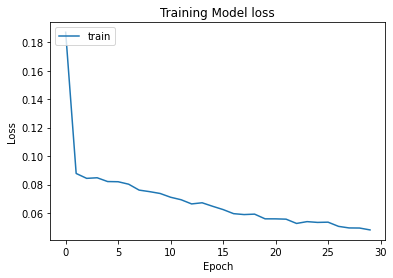

197
           date     Actual  Predicted
0    2019-04-12  40.507534  40.232090
1    2019-04-15  40.591747  40.359235
2    2019-04-17  40.554325  40.342399
3    2019-04-22  40.273605  40.268082
4    2019-04-23  39.918026  39.899026
..          ...        ...        ...
192  2020-01-30  41.956577  42.276834
193  2020-01-31  43.992935  42.686658
194  2020-02-03  42.993965  42.895314
195  2020-02-04  43.186077  43.222695
196  2020-02-05  43.579899  43.482392

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0382 - mean_squared_error: 0.0382
LSTM Model Loss =  [0.03823591396212578, 0.03823591396212578]
Model Accuracy =  99.36619585640281
Mean Absolute Error =  0.25016676300563506  degrees
Mean Squared Error =  0.1426702229293101
Root Mean Squared Error =  0.377717120249149

--------------------------------------------------------------------------

Evaluating Model for Company:  GOOG
Epoch 1/30
73/73 [===================

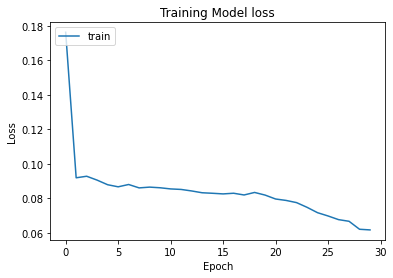

197
           date       Actual    Predicted
0    2019-04-12  1204.619995  1197.535710
1    2019-04-15  1217.869995  1214.265797
2    2019-04-17  1221.099976  1218.796597
3    2019-04-22  1236.339966  1235.545805
4    2019-04-23  1248.839966  1247.417427
..          ...          ...          ...
192  2020-01-30  1458.630005  1447.703736
193  2020-01-31  1455.839966  1451.029190
194  2020-02-03  1434.229980  1454.322112
195  2020-02-04  1485.939941  1455.286437
196  2020-02-05  1447.069946  1455.476698

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0699 - mean_squared_error: 0.0699
LSTM Model Loss =  [0.06993848830461502, 0.06993848830461502]
Model Accuracy =  99.05097298270424
Mean Absolute Error =  11.578772408863756  degrees
Mean Squared Error =  254.16486689214832
Root Mean Squared Error =  15.942548945891568

--------------------------------------------------------------------------

Evaluating Model for Comp

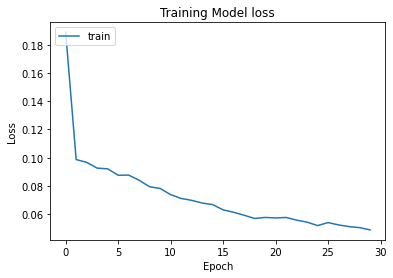

197
           date     Actual  Predicted
0    2019-04-12  35.292530  35.300739
1    2019-04-15  35.146770  35.325791
2    2019-04-17  35.205078  35.559125
3    2019-04-22  34.952431  35.086430
4    2019-04-23  35.127342  35.096454
..          ...        ...        ...
192  2020-01-30  33.982201  33.973418
193  2020-01-31  34.453903  34.191547
194  2020-02-03  32.979836  32.965120
195  2020-02-04  33.795483  33.420843
196  2020-02-05  36.763275  35.536221

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0646 - mean_squared_error: 0.0646
LSTM Model Loss =  [0.06462723761796951, 0.06462723761796951]
Model Accuracy =  99.21176761295732
Mean Absolute Error =  0.2910358138056636  degrees
Mean Squared Error =  0.17319958654922113
Root Mean Squared Error =  0.4161725442039889

--------------------------------------------------------------------------

Evaluating Model for Company:  XOM
Epoch 1/30
73/73 [===================

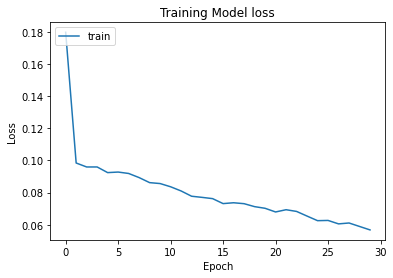

197
           date     Actual  Predicted
0    2019-04-12  72.001968  72.770311
1    2019-04-15  71.097000  72.626098
2    2019-04-17  70.859787  70.872423
3    2019-04-22  71.545097  71.436373
4    2019-04-23  72.836647  71.930293
..          ...        ...        ...
192  2020-01-30  58.377277  58.489709
193  2020-01-31  58.996475  59.215035
194  2020-02-03  56.565224  56.675441
195  2020-02-04  55.299515  55.448769
196  2020-02-05  54.607475  54.766600

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0697 - mean_squared_error: 0.0697
LSTM Model Loss =  [0.06972921639680862, 0.06972921639680862]
Model Accuracy =  99.26438112328378
Mean Absolute Error =  0.4742866076912478  degrees
Mean Squared Error =  0.4267475095216757
Root Mean Squared Error =  0.6532591442311969

--------------------------------------------------------------------------

Evaluating Model for Company:  ABT
Epoch 1/30
73/73 [====================

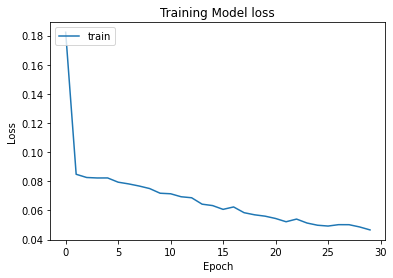

197
           date     Actual  Predicted
0    2019-04-12  76.076523  76.583771
1    2019-04-15  75.901398  75.960998
2    2019-04-17  75.405174  75.487941
3    2019-04-22  70.910042  71.112584
4    2019-04-23  72.495987  71.892997
..          ...        ...        ...
192  2020-01-30  87.775566  89.079066
193  2020-01-31  87.795273  89.244166
194  2020-02-03  85.806183  86.035842
195  2020-02-04  85.727409  86.457339
196  2020-02-05  86.879509  87.146770

[197 rows x 3 columns]

-----Model Evaluation-----------------------------------------------------

7/7 - 0s - loss: 0.0684 - mean_squared_error: 0.0684
LSTM Model Loss =  [0.06838005781173706, 0.06838005781173706]
Model Accuracy =  99.26806870104663
Mean Absolute Error =  0.5934477327937528  degrees
Mean Squared Error =  0.5981217073360754
Root Mean Squared Error =  0.7733832861757974

--------------------------------------------------------------------------



In [21]:
for i in range(len(company_tickers)):
  company = company_tickers[i]
  print("Evaluating Model for Company: ",company)
  df_name = "CS_stock_and_news_"+company+".csv"
  # Load dataset of a particular company
  df = pd.read_csv(df_name, index_col=0)
  hist, model, df_compare, Accuracy, MAE, MSE, RMSE = DP_LSTM(company, df)
  company_results = company_results.append({'company': company, 'MAE': MAE,'MSE':MSE, 'Accuracy': Accuracy, 'RMSE':RMSE}, ignore_index=True)
  

In [25]:
company_results

,company,MAE,MSE,Accuracy,RMSE
0,AAPL,0.418989,0.313967,99.213501,0.560328
1,AMZN,14.957059,415.605390,99.188584,20.386402
2,ADM,0.250167,0.142670,99.366196,0.377717
3,GOOG,11.578772,254.164867,99.050973,15.942549
4,EBAY,0.291036,0.173200,99.211768,0.416173
5,XOM,0.474287,0.426748,99.264381,0.653259
6,ABT,0.593448,0.598122,99.268069,0.773383


In [27]:
# Mean Accuracy for DP-LSTM
mean_results = company_results.mean(axis = 0)
mean_results

MAE          4.080537
MSE         95.917852
Accuracy    99.223353
RMSE         5.587116
dtype: float64

In [28]:
now = datetime.now()
current_time = now.strftime("%H%M%S")
name = "P6_LSTM_company_specific_dplstm"+current_time+".csv"
company_results.to_csv(name)